### Imports

In [1]:
from glob import glob
from scipy.ndimage import label
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import os
import enum
import json
import glob

### Functions

In [2]:
class SegType(enum.Enum):
    NO_LABEL = 0
    GOLD_SEED = 1
    CALCIFICATION = 2

In [3]:
def get_cropped_regions(mask, vals, cropsize=10):
    
    labeled_mask, num_labels = label(
        input=mask,
        structure=np.ones((3, 3, 3))
    )

    cropped_regions = []
    cropped_masks = []

    for region_label in range(1, num_labels+1):
        coords = np.argwhere(labeled_mask == region_label)

        centroid = np.mean(coords, axis=0)
        centroid = np.round(centroid).astype(int)

        half_cropsize = cropsize // 2

        submask = mask[
            centroid[0]-half_cropsize:centroid[0]+half_cropsize,
            centroid[1]-half_cropsize:centroid[1]+half_cropsize,
            centroid[2]-half_cropsize:centroid[2]+half_cropsize
        ]
        subvals = vals[
            centroid[0]-half_cropsize:centroid[0]+half_cropsize,
            centroid[1]-half_cropsize:centroid[1]+half_cropsize,
            centroid[2]-half_cropsize:centroid[2]+half_cropsize
        ]

        cropped_regions.append(subvals)
        cropped_masks.append(submask)

    return cropped_regions, cropped_masks

In [4]:
def get_region_stats(seg, vals):
    counts = {}
    means = {}
    stds = {}

    for label_id in np.unique(seg):
        if label_id == 0: continue
        
        labels, num_labels = label(
            seg * np.array((seg == label_id), int),
            structure=np.ones((3, 3, 3))
        )

        region_counts = []
        region_means = []
        region_stds = []
        for i in range(1, num_labels+1):
            mask = (labels == i)
            region_counts.append(np.sum(mask))
            region_means.append(np.mean(vals[mask]))
            region_stds.append(np.std(vals[mask]))

        counts[label_id] = region_counts
        means[label_id] = region_means
        stds[label_id] = region_stds

    return counts, means, stds

In [5]:
def update_dict(original_dict, other_dict):
    for key in original_dict:
        if key in other_dict:
            original_dict[key].extend(other_dict[key])
        else:
            original_dict[key] = other_dict[key]
    return original_dict

### Load data

In [6]:
bids_dir = "bids-new"

In [7]:
session_dirs = []
for json_path in sorted(glob.glob(os.path.join(bids_dir, "sub*", "ses*", "anat", "*echo-01*mag*json"))):
    with open(json_path, 'r') as json_file:
        json_data = json.load(json_file)
        if json_data['ProtocolName'] == "t2starME_qsm_tra_Iso1.4mm_INPHASE_bipolar_RUN_THIS_ONE":
            session_dirs.append(os.sep.join(os.path.split(json_path)[0].split(os.sep)[:-1]))
print(f"{len(session_dirs)} sessions found:")
for session_dir in session_dirs: print(session_dir)

18 sessions found:
bids-new/sub-z0034542/ses-20220715
bids-new/sub-z0186251/ses-20221107
bids-new/sub-z0237546/ses-20230508
bids-new/sub-z0445614/ses-20230510
bids-new/sub-z0705200/ses-20230104
bids-new/sub-z0755228/ses-20211108
bids-new/sub-z1167038/ses-20220315
bids-new/sub-z1181657/ses-20220315
bids-new/sub-z1262112/ses-20220314
bids-new/sub-z1472355/ses-20221222
bids-new/sub-z1568577/ses-20230510
bids-new/sub-z1728751/ses-20220328
bids-new/sub-z1778013/ses-20220715
bids-new/sub-z1818796/ses-20230313
bids-new/sub-z2007565/ses-20220715
bids-new/sub-z2904752/ses-20220826
bids-new/sub-z3171177/ses-20230313
bids-new/sub-z3278008/ses-20211109


In [8]:
qsm_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*qsm_echo2-and-echo4.*")) for session_dir in session_dirs), []))
seg_clean_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "sub*ses*segmentation_clean.*")) for session_dir in session_dirs), []))
t1_resampled_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*t1_tra*_resampled.nii*")) for session_dir in session_dirs), []))
t2s_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*t2starmap.nii*")) for session_dir in session_dirs), []))
mag_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "magnitude_combined.nii")) for session_dir in session_dirs), []))

t1_files = [t1_file.replace("_resampled", "") for t1_file in t1_resampled_files]
seg_files = [seg_clean_file.replace("_clean", "") for seg_clean_file in seg_clean_files]

extra_files = sum((glob.glob(os.path.join(session_dir, "extra_data", "*.nii*")) for session_dir in session_dirs), [])
ct_files = [extra_file for extra_file in extra_files if any(pattern in extra_file for pattern in ['_na_', '_Pelvis_']) and not any(pattern in extra_file for pattern in ['_t1_tra_', 'ATX', 'AXT', 'ROI', 'resliced', 'segmentation'])]

ct_seg_files = sum((glob.glob(ct_file.replace(".nii", "_segmentation_clean.nii")) for ct_file in ct_files), [])
ct_resliced_files = sum((glob.glob(ct_file.replace(".nii", "_resliced.nii")) for ct_file in ct_files), [])
ct_resliced_seg_files = sum((glob.glob(ct_file.replace(".nii", "_segmentation_clean.nii")) for ct_file in ct_resliced_files), [])

ct_files = [ct_file for ct_file in ct_files if 'z0237546' not in ct_file]
ct_seg_files = [ct_file for ct_file in ct_seg_files if 'z0237546' not in ct_file]
ct_resliced_files = [ct_file for ct_file in ct_resliced_files if 'z0237546' not in ct_file]
ct_resliced_seg_files = [ct_file for ct_file in ct_resliced_seg_files if 'z0237546' not in ct_file]

print(f"{len(ct_files)} CT images found.")
print(f"{len(ct_seg_files)} CT segmentations found.")
print(f"{len(ct_resliced_files)} resliced CT images found.")
print(f"{len(ct_resliced_seg_files)} resliced CT segmentations found.")
print(f"{len(qsm_files)} QSM images found.")
print(f"{len(mag_files)} magnitude images found.")
print(f"{len(t2s_files)} T2* maps found.")
print(f"{len(t1_files)} T1w files found.")
print(f"{len(t1_resampled_files)} resampled T1w files found.")
print(f"{len(seg_files)} GRE segmentations found.")
print(f"{len(seg_clean_files)} cleaned GRE segmentations found.")

17 CT images found.
17 CT segmentations found.
17 resliced CT images found.
17 resliced CT segmentations found.
18 QSM images found.
18 magnitude images found.
18 T2* maps found.
18 T1w files found.
18 resampled T1w files found.
18 GRE segmentations found.
18 cleaned GRE segmentations found.


In [9]:
seed_sizes = []
seed_means = []
seed_stds = []
seed_segmentations = []
regions_vals = []
regions_masks = []
regions_segmentations = []

for i in range(len(seg_clean_files)):
    # load images
    print(seg_clean_files[i])
    seg = nib.load(seg_clean_files[i]).get_fdata()
    qsm = nib.load(qsm_files[i]).get_fdata()

    # get region stats
    counts, means, stds = get_region_stats(seg, qsm)
    try:
        seed_sizes.extend(counts[SegType.GOLD_SEED.value])
        seed_means.extend(means[SegType.GOLD_SEED.value])
        seed_stds.extend(stds[SegType.GOLD_SEED.value])
        seed_segmentations.extend(os.path.split(seg_clean_files[i])[1] for x in range(len(counts[SegType.GOLD_SEED.value])))
    except:
        print(f"No goldseed found in {seg_clean_files[i]}")
        continue

    # get regions
    connected_regions_vals, connected_regions_masks = get_cropped_regions(
        mask=seg == SegType.GOLD_SEED.value,
        vals=qsm,
        cropsize=20
    )
    regions_vals.extend(connected_regions_vals)
    regions_masks.extend(connected_regions_masks)
    regions_segmentations.extend([seg_clean_files[i] for x in range(len(connected_regions_vals))])


# create dataframe
seed_data = {
    "size": seed_sizes,
    "mean": seed_means,
    "std": seed_stds,
    "file" : seed_segmentations
}
seed_df = pd.DataFrame(seed_data).sort_values("size")

bids-new/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_segmentation_clean.nii.gz


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


bids-new/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_run-01_segmentation_clean.nii.gz
bids-new/sub-z0237546/ses-20230508/extra_data/sub-z0237546_ses-20230508_run-01_segmentation_clean.nii
bids-new/sub-z0445614/ses-20230510/extra_data/sub-z0445614_ses-20230510_run-01_segmentation_clean.nii
bids-new/sub-z0705200/ses-20230104/extra_data/sub-z0705200_ses-20230104_run-01_segmentation_clean.nii
bids-new/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_run-01_segmentation_clean.nii.gz
bids-new/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_segmentation_clean.nii.gz
bids-new/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-20220315_run-01_segmentation_clean.nii.gz
bids-new/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_segmentation_clean.nii.gz
bids-new/sub-z1472355/ses-20221222/extra_data/sub-z1472355_ses-20221222_run-01_segmentation_clean.nii
bids-new/sub-z1568577/ses-20230510/extra_data/sub-z1568577_ses-2023

In [10]:
seed_df.sort_values("file")

,size,mean,std,file
0,38,-0.252126,0.247724,sub-z0034542_ses-20220715_run-01_segmentation_...
1,35,-0.122237,0.244349,sub-z0034542_ses-20220715_run-01_segmentation_...
2,28,-0.233854,0.244340,sub-z0034542_ses-20220715_run-01_segmentation_...
5,5,-0.309916,0.157637,sub-z0186251_ses-20221107_run-01_segmentation_...
3,7,-0.385144,0.205846,sub-z0186251_ses-20221107_run-01_segmentation_...
4,22,-0.372171,0.213685,sub-z0186251_ses-20221107_run-01_segmentation_...
7,35,-0.318892,0.156672,sub-z0237546_ses-20230508_run-01_segmentation_...
8,29,-0.304491,0.173480,sub-z0237546_ses-20230508_run-01_segmentation_...
6,51,0.119786,0.357718,sub-z0237546_ses-20230508_run-01_segmentation_...
9,10,-0.027267,0.280323,sub-z0445614_ses-20230510_run-01_segmentation_...


### Visualise data

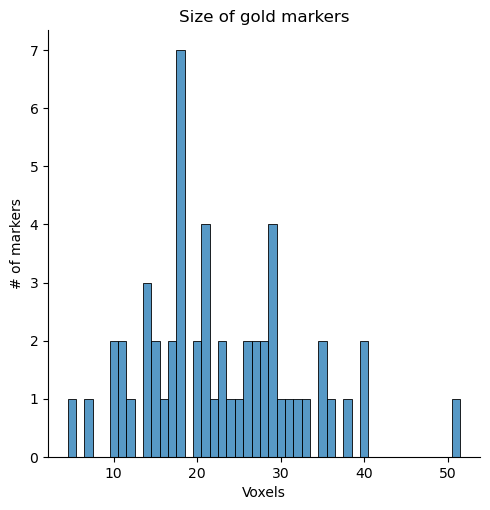

In [11]:
sns.displot(seed_data, x='size', discrete=True)
plt.xlabel("Voxels")
plt.ylabel("# of markers")
plt.title("Size of gold markers")
plt.savefig("seed_size_histogram.png", bbox_inches='tight')
plt.show()

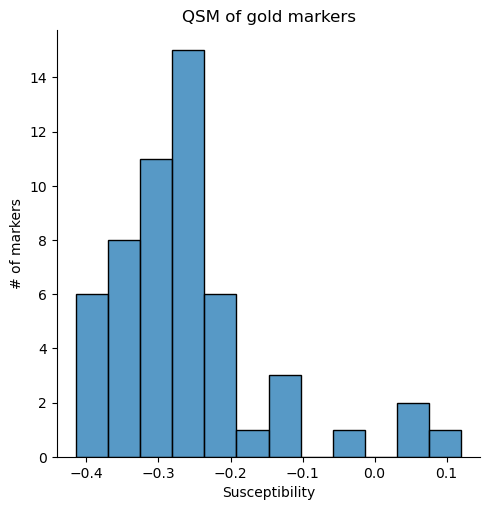

In [12]:
sns.displot(seed_data, x='mean')
plt.xlabel("Susceptibility")
plt.ylabel("# of markers")
plt.title("QSM of gold markers")
plt.savefig("seed_qsm_histogram.png", bbox_inches='tight')
plt.show()

54


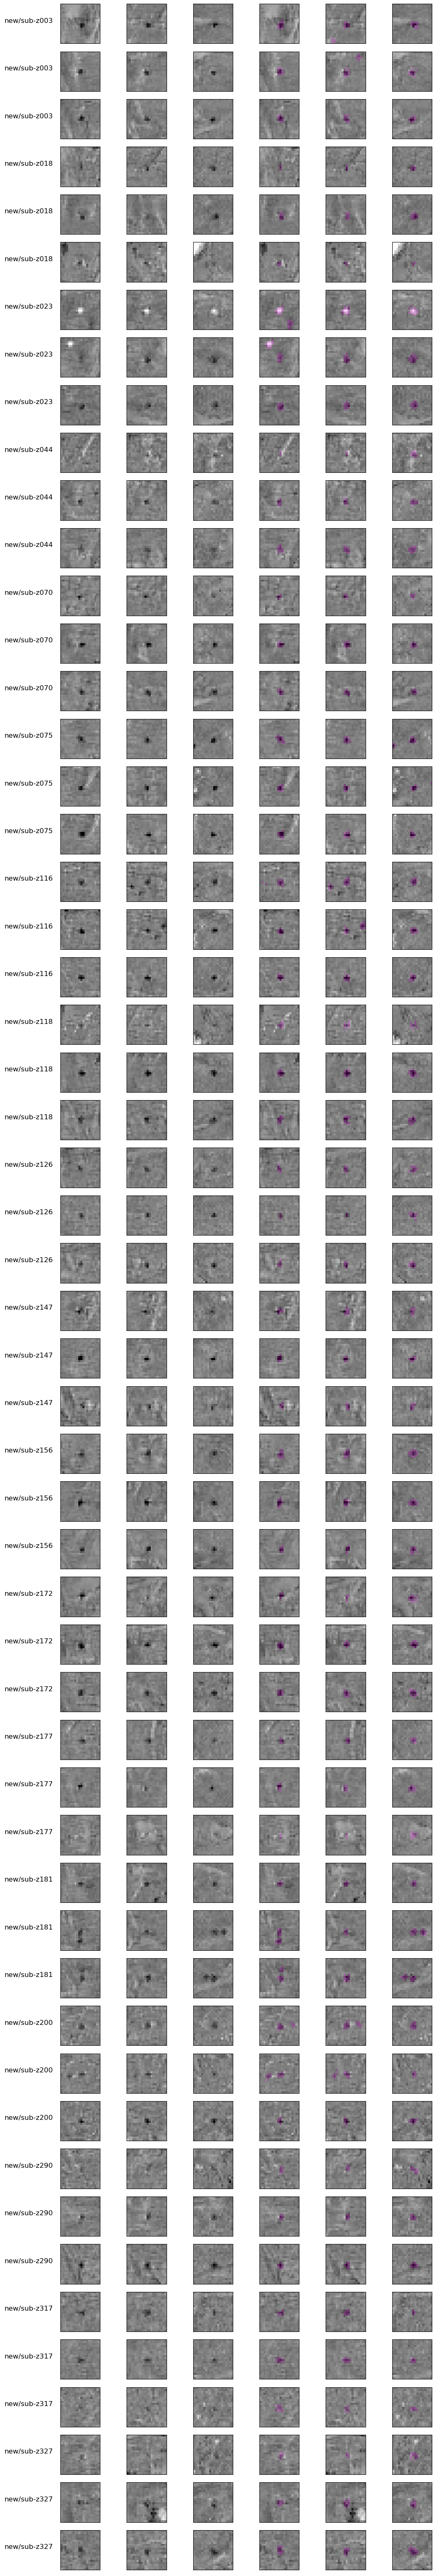

In [13]:
fig, axes = plt.subplots(ncols=6, nrows=len(regions_vals), figsize=(12, 80))

for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

print(len(regions_vals))
for i in range(len(regions_vals)):
    axes[i,0].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,1].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,2].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,4].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,5].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_masks[i][regions_vals[i].shape[0]//2,:,:], cmap='cool', alpha=np.array(regions_masks[i][regions_vals[i].shape[0]//2,:,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,4].imshow(regions_masks[i][:,regions_vals[i].shape[1]//2,:], cmap='cool', alpha=np.array(regions_masks[i][:,regions_vals[i].shape[1]//2,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,5].imshow(regions_masks[i][:,:,regions_vals[i].shape[2]//2], cmap='cool', alpha=np.array(regions_masks[i][:,:,regions_vals[i].shape[2]//2] * 0.2, dtype=float), vmin=0, vmax=1)

    axes[i,0].set_ylabel(regions_segmentations[i][5:17], rotation=0, fontsize=12, labelpad=55)

plt.savefig("seeds.png", bbox_inches='tight')
plt.show()
plt.close()

In [14]:
calc_sizes = []
calc_means = []
calc_stds = []
calc_segmentations = []
regions_vals = []
regions_masks = []
regions_segmentations = []

for i in range(len(seg_clean_files)):
    # load images
    seg = nib.load(seg_clean_files[i]).get_fdata()
    qsm = nib.load(qsm_files[i]).get_fdata()

    # get region stats
    counts, means, stds = get_region_stats(seg, qsm)
    print(counts)
    try:
        calc_sizes.extend(counts[SegType.CALCIFICATION.value])
        calc_means.extend(means[SegType.CALCIFICATION.value])
        calc_stds.extend(stds[SegType.CALCIFICATION.value])
        calc_segmentations.extend(os.path.split(seg_clean_files[i])[1] for x in range(len(counts[SegType.CALCIFICATION.value])))
    except:
        print(f"No calcification found in {seg_clean_files[i]}")
        continue

    # get regions
    connected_regions_vals, connected_regions_masks = get_cropped_regions(
        mask=seg == SegType.CALCIFICATION.value,
        vals=qsm,
        cropsize=20
    )
    regions_vals.extend(connected_regions_vals)
    regions_masks.extend(connected_regions_masks)
    regions_segmentations.extend([seg_clean_files[i] for x in range(len(connected_regions_vals))])


# create dataframe
calc_data = {
    "size": calc_sizes,
    "mean": calc_means,
    "std": calc_stds,
    "file" : calc_segmentations
}
calc_df = pd.DataFrame(calc_data).sort_values("size")

/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


{1.0: [38, 35, 28], 2.0: [325, 7, 242, 22388, 255, 26, 6328, 106, 7, 7, 7, 18, 47, 126, 110, 14, 63, 27, 53, 2135, 65, 12, 18, 94, 7, 379, 26, 7, 7, 33, 12, 7, 120, 7, 38, 50, 16, 7, 7, 7, 7, 7, 20, 228, 7, 7, 19, 132, 12, 26, 12, 7, 12, 105, 7, 7, 87, 33, 84, 12, 12, 282, 7, 12, 14, 95, 7, 3336, 127, 22, 7, 7, 14, 12, 7, 56, 12, 7, 7, 1074, 40, 7, 7, 2207, 107, 7, 12, 35, 12, 7, 7, 7, 85, 21, 197, 14, 3867, 26, 7, 60, 517, 7, 7, 19, 12, 58, 12, 23, 7, 7, 7, 334, 7, 35, 150, 7, 7, 58, 26, 3917, 7, 7, 7, 7, 7, 133, 19, 12, 85, 7, 30, 70, 7, 29, 58, 27, 7, 43, 7, 12, 7, 7, 19, 7, 7, 14, 12, 7, 7, 7, 7, 7, 42, 101, 14, 16, 7, 158, 45, 96, 7, 12, 27, 30, 67, 7, 17, 7, 19, 7, 7, 7, 89, 327, 7, 55, 235, 24, 79, 38, 7, 7, 7, 12, 296, 7, 7, 7, 7, 7, 35, 7, 7, 101, 12, 7, 12, 18, 7, 7, 7, 12, 304, 250, 882, 20, 14, 7, 7, 36, 7, 12, 39, 7, 7, 14, 7, 12, 26720, 19, 26, 17, 7, 12, 352, 55, 7, 19, 7, 263, 7, 7, 7, 144, 41, 313, 108, 1219, 7, 30, 33, 7, 7, 18, 14, 65, 44, 7, 14, 17, 7, 12, 82, 7, 7,

KeyboardInterrupt: 

In [ ]:
sns.displot(calc_data, x='size', discrete=True)
plt.xlabel("Voxels")
plt.ylabel("# of calcification regions")
plt.xlim(0, 50)
plt.title("Size of calcification region")
plt.savefig("calc_size_histogram.png", bbox_inches='tight')
plt.show()

In [ ]:
sns.displot(calc_data, x='mean')
plt.xlabel("Susceptibility")
plt.ylabel("# of calcification regions")
plt.title("QSM of calcification")
plt.savefig("calc_qsm_histogram.png", bbox_inches='tight')
plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=6, nrows=len(regions_vals), figsize=(12, 80))

for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

print(len(regions_vals))
for i in range(len(regions_vals)):
    axes[i,0].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,1].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,2].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,4].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,5].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_masks[i][regions_vals[i].shape[0]//2,:,:], cmap='cool', alpha=np.array(regions_masks[i][regions_vals[i].shape[0]//2,:,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,4].imshow(regions_masks[i][:,regions_vals[i].shape[1]//2,:], cmap='cool', alpha=np.array(regions_masks[i][:,regions_vals[i].shape[1]//2,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,5].imshow(regions_masks[i][:,:,regions_vals[i].shape[2]//2], cmap='cool', alpha=np.array(regions_masks[i][:,:,regions_vals[i].shape[2]//2] * 0.2, dtype=float), vmin=0, vmax=1)

    axes[i,0].set_ylabel(regions_segmentations[i][5:17], rotation=0, fontsize=12, labelpad=55)

plt.savefig("seeds.png", bbox_inches='tight')
plt.show()
plt.close()